In [1]:
exist = !which ffmpeg
if not exist:
    !curl https://johnvansickle.com/ffmpeg/releases/ffmpeg-release-amd64-static.tar.xz -o ffmpeg.tar.xz \
       && tar -xf ffmpega.tar.xz && rm ffmpeg.tar.xz
    ffmdir = !find . -iname ffmpeg-*-static
    path = %env PATH
    path = path + ':' + ffmdir[0]
    %env PATH $path
print('')
!which ffmpeg
print('Done!')


/usr/bin/ffmpeg
Done!


In [2]:
import shapely, collections, pygad, matplotlib, random, warnings,copy, operator, pickle, json
from sklearn.preprocessing import MinMaxScaler
from gym.spaces import Discrete
import numpy as np
from operator import itemgetter
from numpy.random import choice
warnings.filterwarnings('ignore')
from celluloid import Camera
from shapely.geometry import Polygon, Point, LineString
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import torch
import torch.nn as nn
torch.autograd.set_grad_enabled(False)
from pygad import torchga

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


file = open('data/scores_prob.json')
scores = json.load(file)
x_team_l = scores['x_team_l']
x_team_r = scores['x_team_r']
y_score = scores['y_score']
global x_team_l, x_team_r, y_score

file.close()

In [3]:
class Basketball_Environment():

    def __init__(self):

        self.action_space = Discrete(15)
        self.reward = int()

        self.players =  { 0 : { # 'team_left'
                          0 : [2,5], #'pg' point guard
                          1 : [4,6], #'sg' shooting guard
                          2 : [5,2], #'sf' small forward
                          3 : [1,6], #'pf' power forward
                          4 : [2,3]  #'c' center
                      },
                          1 : { # 'team_right'
                          0 : [10,4], #'pg'
                          1 : [10,1], #'sg'
                          2 : [14,5], #'sf'
                          3 : [13,2], #'pf'
                          4 : [11,6]  #'c'
                                   }
                              }



        self.starting_state = {
              'team_left' : {
                      'pg' : [6,5],
                      'sg' : [4,6],
                      'sf' : [5,2],
                      'pf' : [1,6],
                      'c'  : [2,3]
                  },
              'team_right' : {
                      'pg' : [10,4],
                      'sg' : [10,1],
                      'sf' : [14,5],
                      'pf' : [13,2],
                      'c'  : [11,6]
                              }
                          }
        self.steps_counter = int()
        self.X_axis = 15
        self.Y_axis = int(self.X_axis / 2) + 2 # it's 9
        grid_world = np.zeros((1, self.Y_axis, self.X_axis))[0]

        self.basket = {"L":[0.6, 4.5], # team left's basket
                       "R":[14.4, 4.5]}      # team right's basket

        self.observation_space = np.array([None] * 19)
        self.whole_observation_space = np.array([None] * 190).reshape(10,19)
        self.num_teams = len(self.players.keys())
        self.num_players = len(self.players[0].values())
        self.ball_location = np.array([None] * 2)
        self.five_sec_violation = [False] * 5
        self.step_ = 0.2
        self.tmp_location = np.array([None] * 2)
        self.p_id = [None] * 2
        
        self.scores = {"team_left": int(), "team_right": int()}
        self.rm =  {'00': [False] * 10, # if individuals stays at one position for 10 steps, then they're forcibly moved by a random action
                    '01': [False] * 10,
                    '02': [False] * 10,
                    '03': [False] * 10,
                    '04': [False] * 10,
                    '10': [False] * 10,
                    '11': [False] * 10,
                    '12': [False] * 10,
                    '13': [False] * 10,
                    '14': [False] * 10}

        self.indiv_reward =  {'00': int(), # this is for analysis of individual reward
                              '01': int(),
                              '02': int(),
                              '03': int(),
                              '04': int(),
                              '10': int(),
                              '11': int(),
                              '12': int(),
                              '13': int(),
                              '14': int()}
        
        self.fga =       {'00': int(), 
                              '01': int(),
                              '02': int(),
                              '03': int(),
                              '04': int(),
                              '10': int(),
                              '11': int(),
                              '12': int(),
                              '13': int(),
                              '14': int()}
        self.fgm =       {'00': int(), 
                              '01': int(),
                              '02': int(),
                              '03': int(),
                              '04': int(),
                              '10': int(),
                              '11': int(),
                              '12': int(),
                              '13': int(),
                              '14': int()}
        self.stl =       {'00': int(), 
                              '01': int(),
                              '02': int(),
                              '03': int(),
                              '04': int(),
                              '10': int(),
                              '11': int(),
                              '12': int(),
                              '13': int(),
                              '14': int()}
        self.stl_attempt =       {'00': int(), 
                              '01': int(),
                              '02': int(),
                              '03': int(),
                              '04': int(),
                              '10': int(),
                              '11': int(),
                              '12': int(),
                              '13': int(),
                              '14': int()}
        self.offensive = " "
        self.defensive = " "
        self.Lreward = int()
        self.Rreward = int()
        self.prev_ball_owner = [None] * 2
        
    
    def score_prob(self,x_score_team_l, x_score_team_r, y_score, ball_holder_position, team):
        x_score_team_l = x_team_l
        x_score_team_r = x_team_r
        y_score = y_score
        ball_holder_position = np.round(ball_holder_position.astype(float),1)
        if team == 0:
            if float(ball_holder_position[0]) <= 7.5:
                return 0.0
            if float(ball_holder_position[1]) < 0:
                return 0.0
            if float(ball_holder_position[0]) < 0:
                return 0.0
            if float(ball_holder_position[1]) > 9.0:
                return 0.0
            if float(ball_holder_position[0]) > 15.0:
                return 0.0
            else: 
                prob = x_score_team_l[str(ball_holder_position[0])] +  y_score[str(ball_holder_position[1])]
                if prob < 0:
                    return 0.0
                else:
                    return prob
        if team == 1:
            if float(ball_holder_position[0]) >= 7.5:
                return 0.0
            if float(ball_holder_position[1]) < 0:
                return 0.0
            if float(ball_holder_position[0]) < 0:
                return 0.0
            if float(ball_holder_position[1]) > 9.0:
                return 0.0
            if float(ball_holder_position[0]) > 15.0:
                return 0.0
            else: 
                prob = x_score_team_l[str(ball_holder_position[0])] +  y_score[str(ball_holder_position[1])]
                if prob < 0:
                    return 0.0
                else:
                    return prob

    def move(self,agent_curr_loc, act=int, team=int,info=False, steps=int):

        """Considering the player looking forward in the court which is 'right hand side' from 3rd person view! """
        """Meaning player looking forward is your right."""

        x_axis, y_axis = 0, 1 # this only refers to left and right of the matrix
        XX,YY = [0,self.X_axis], [0,self.Y_axis] # this refers to along side on the x/y axis

        steps = self.step_
        if team == 0:
            if act == 0:                                   # right = 0
                agent_curr_loc[y_axis] -= steps
                if info:
                    print("right = 0")
        ########################################################################################
            if act == 1:                                   # forward - right = 1
                agent_curr_loc[x_axis] += steps
                agent_curr_loc[y_axis] -= steps
                if info:
                    print("forward - right = 1")
        ########################################################################################
            if act == 2:                                   # forward = 2
                agent_curr_loc[x_axis] += steps
                if info:
                    print("forward = 2")
        ########################################################################################
            if act == 3:                                   # forward -left = 3
                agent_curr_loc[x_axis] += steps
                agent_curr_loc[y_axis] += steps
                if info:
                    print("forward - left = 3")
        ########################################################################################
            if act == 4:                                   # left = 4
                agent_curr_loc[y_axis] += steps
                if info:
                    print("left = 4")
        ########################################################################################
            if act == 5:                                   # left - backward = 5
                agent_curr_loc[x_axis] -= steps
                agent_curr_loc[y_axis] += steps
                if info:
                    print("left - backward = 5")
        ########################################################################################
            if act == 6:                                   # backward = 6
                agent_curr_loc[x_axis] -= steps
                if info:
                    print("backward = 6")
        ########################################################################################
            if act == 7:                                   # right - backward = 7
                agent_curr_loc[x_axis] -= steps
                agent_curr_loc[y_axis] -= steps
                if info:
                    print("right - backward = 7")
        ########################################################################################
            if act == 8:                                   # does nothing = 8
                agent_curr_loc[x_axis] += 0
                agent_curr_loc[y_axis] += 0
                if info:
                    print("does nothing = 8")

        if team == 1:
            if act == 0:                                   # right = 0
                agent_curr_loc[y_axis] += steps
                if info:
                    print("right = 0")
        ########################################################################################
            if act == 1:                                   # forward - right = 1
                agent_curr_loc[x_axis] -= steps
                agent_curr_loc[y_axis] += steps
                if info:
                    print("forward - right = 1")
        ########################################################################################
            if act == 2:                                   # forward = 2
                agent_curr_loc[x_axis] -= steps
                if info:
                    print("forward = 2")
        ########################################################################################
            if act == 3:                                   # forward - left = 3
                agent_curr_loc[x_axis] -= steps
                agent_curr_loc[y_axis] -= steps
                if info:
                    print("forward - left = 3")
        ########################################################################################
            if act == 4:                                   # left = 4
                agent_curr_loc[y_axis] -= steps
                if info:
                    print("left = 4")
        ########################################################################################
            if act == 5:                                   # backward - left = 5
                agent_curr_loc[x_axis] += steps
                agent_curr_loc[y_axis] -= steps
                if info:
                    print("backward - left = 5")
        ########################################################################################
            if act == 6:                                   # backaward = 6
                agent_curr_loc[x_axis] += steps
                if info:
                    print("backward = 6")
        ########################################################################################
            if act == 7:                                   # backward - right = 7
                agent_curr_loc[x_axis] += steps
                agent_curr_loc[y_axis] += steps
                if info:
                    print("backward - right = 7")
        ########################################################################################
            if act == 8:                                   # does nothing = 8
                agent_curr_loc[x_axis] += 0
                agent_curr_loc[y_axis] += 0
                if info:
                    print("does nothing = 8")

        return agent_curr_loc
####################################################################################################
    def r_pos(self,team=int):
        # returns a random position for players
        y = np.round(np.random.uniform(1, 8, 1),1)[0]
        if team == 0:
            x = np.round(np.random.uniform(1, 7, 1),1)[0]
            return [x,y]
        if team == 1:
            x = np.round(np.random.uniform(8, 14, 1),1)[0]
            return [x,y]     

    def observation_space_n(self):
        return len(self.observation_space)

    def pr(self, prob):
        _random = random.random()
        return True if _random <= prob else False


    def id_p_location(self,observation_space, agent_curr_loc):
        # given the location of a player, it returns the p_id
        for i in observation_space[:,:4]:
            if (list(i[2:4]) == agent_curr_loc) == True:

                return i[:2] # returns the id of the agent

    def p_id_location(self,observation_space, id_):
        # given the id of a player, it returns the player's location
        for i in observation_space[:,:4]:
            if (list(i[:2]) == id_) == True:
                return i[2:4] # returns the agent's location


    def pass_(self,observation_space, agent_curr_loc, random=True, info=False):

        a = observation_space
        team = a[:,:2][np.where(a[:,4])[0][0]][0]
        p_id = a[:,:2][np.where(a[:,4])[0][0]]

        val = a[:5] if team == 0 else a[5:]
        the_nearest_one = np.random.randint(5) if random else 0 # the first element in the list.
        nearest = sorted(list(val[:,2:4]), key=itemgetter(1))[the_nearest_one]
        p_id = self.id_p_location(a,list(nearest))
        ball_location = nearest

        if info:
            print(f"p_id: {p_id}, ball_location: {ball_location}")

        return p_id, ball_location

    def tip_off(self): 
        # who gets the ball first
        player = np.random.choice([0,5])
        ball_holder_id = [0 if player == 0 else 0, 0]
        return ball_holder_id

    def reset(self,random_pos=True):
        if random_pos:
            players =  { 0 : { # 'team_left'
                          0 : self.r_pos(0), #'pg' point guard
                          1 : self.r_pos(0), #'sg' shooting guard
                          2 : self.r_pos(0), #'sf' small forward
                          3 : self.r_pos(0), #'pf' power forward
                          4 : self.r_pos(0)  #'c' center
                      },
                          1 : { # 'team_right'
                          0 : self.r_pos(1), #'pg'
                          1 : self.r_pos(1), #'sg'
                          2 : self.r_pos(1), #'sf'
                          3 : self.r_pos(1), #'pf'
                          4 : self.r_pos(1)  #'c'
                                   }
                              }
        indiv_obs = np.array([None] * 19)
        cnt = 0
        c = np.random.randint(0,5)
        for t in range(self.num_teams):
            for p in range(self.num_players):
                indiv_obs[0] = t
                indiv_obs[1] = p
                indiv_obs[2:4] = self.players[t][p] if not random_pos else players[t][p]
                indiv_obs[5:7] = [0,0] if not random_pos else players[0][c] # ball location
                val = 1 if indiv_obs[2:4][0] == indiv_obs[5:7][0] and indiv_obs[2:4][1] == indiv_obs[5:7][1] else 0
                indiv_obs[4]= 0 if not random_pos else val
                indiv_obs[7] = 0 if not random_pos else np.linalg.norm(indiv_obs[2:4] - indiv_obs[5:7])
                indiv_obs[8] = np.linalg.norm(np.array(self.basket['R']) - self.players[t][p]) if t == 0 else np.linalg.norm(np.array(self.basket['L']) - self.players[t][p])
                self.whole_observation_space[cnt] = indiv_obs
                cnt +=1
        for j in range(self.whole_observation_space[:,2:4].shape[0]):
            self.whole_observation_space[:,9:][j] = [np.linalg.norm(i - self.whole_observation_space[:,2:4][j]) for i in self.whole_observation_space[:,2:4]]
        tmp = self.whole_observation_space[:,4] # this is in case random position of players are exact same
        if np.where(tmp)[0].shape[0] > 1:
            self.whole_observation_space[:,4] = [1 if i == np.where(tmp)[0][0] else 0 for i in range(10)]
        return self.whole_observation_space.astype(float),self.reward, self.scores, self.indiv_reward, self.fga, self.fgm, self.stl, self.stl_attempt

    def check_locations_validity(self,players_location, X, Y):

        if players_location[1] in Y and players_location[0] in X:
            return True
        else:
            return False

    def ball_owner(self, indiv_obs):
        return True if indiv_obs[4] == 1 else False

    def ball_possession(self,p_id):
        return [1 if p_id == [i,j] else 0 for i in range(2) for j in range(5)]
    
    def id_ball_status(self,observation_space):
        a = observation_space
        return a[:,:4][np.where(a[:,4])[0][0]][:2]


    ###################################################################################################
    def step(self, actions=list,r=True):
        self.steps_counter +=1
        rew = 0.2
        asd = copy.deepcopy(self.whole_observation_space)
        obs = copy.deepcopy(asd)
        ball_status_col = 4
        indiv_obs = np.array([None] * 19)
        observation_space = np.array([None] * 190).reshape(10,19)

        if self.p_id[0] == None or 1 not in self.whole_observation_space[:,4]:
            self.p_id = self.tip_off()
        else:
            pass

        if 1 in self.ball_possession(list(self.p_id))[:5]:
            self.offensive = "left"
            self.defensive = "right"
        else:
            self.offensive = "right"
            self.defensive = "left"
##################################################### STEAL #####################################################
        if np.where(obs[:,4])[0] in [0,1,2,3,4,5,6,7,8,9]: # inji
            if 0 == self.id_ball_status(obs)[0]:
                dist = {}
                for a in range(5):
                    dist[a] = obs[5:,9:][a][:5]
                # distance of each right player to the person who has the ball from left team
                all_closest_to_ball_holder = [dist[i][np.where(obs[:,4])[0][0]] for i in range(5)]
                p_id_catch_ball = [p_id for p_id, dist in enumerate(all_closest_to_ball_holder) if dist <= self.step_ * 3]
                if not p_id_catch_ball:
                    #print("no one is close enough")
                    pass
                else:
                    p_catch_ball = obs[p_id_catch_ball[0]+5]
                    if np.random.choice([True,False],p=[0.5,0.5]):
                        self.ball_location = p_catch_ball[2:4]
                        self.p_id = p_catch_ball[:2]
                        observation_space[:,4] = self.ball_possession(list(self.p_id))
                        observation_space[:,5:7] = self.ball_location
                        self.indiv_reward[str(self.p_id[0])+str(self.p_id[1])] += rew
                        self.stl_attempt[str(self.p_id[0])+str(self.p_id[1])] += 1
                        self.stl[str(self.p_id[0])+str(self.p_id[1])] += 1
                        self.reward += rew
                    else: 
                        self.stl_attempt[str(self.p_id[0])+str(self.p_id[1])] += 1
                        self.indiv_reward[str(self.p_id[0])+str(self.p_id[1])] -= rew
                        self.reward -= rew


            else: pass

            if 1 == self.id_ball_status(obs)[0]:
                dist = {}
                for a in range(5):
                    dist[a] = obs[:5,9:][a][5:]
                # distance of each right player to the person who has the ball from left team

                all_closest_to_ball_holder = [dist[i][np.where(obs[:,4])[0][0]-5] for i in range(5)]
                p_id_catch_ball = [p_id for p_id, dist in enumerate(all_closest_to_ball_holder) if dist <= self.step_ * 3]
                if not p_id_catch_ball:
                    #print("no one is close enough")
                    pass
                else:
                    p_catch_ball = obs[p_id_catch_ball[0]]
                    if np.random.choice([True,False],p=[0.5,0.5]):
                        self.ball_location = p_catch_ball[2:4]
                        self.p_id = p_catch_ball[:2]
                        observation_space[:,4] = self.ball_possession(list(self.p_id))
                        observation_space[:,5:7] = self.ball_location
                        self.indiv_reward[str(self.p_id[0])+str(self.p_id[1])] += rew
                        self.stl_attempt[str(self.p_id[0])+str(self.p_id[1])] += 1
                        self.stl[str(self.p_id[0])+str(self.p_id[1])] += 1
                        self.reward += rew
                    else: 
                        self.stl_attempt[str(self.p_id[0])+str(self.p_id[1])] += 1
                        self.indiv_reward[str(self.p_id[0])+str(self.p_id[1])] -= rew
                        self.reward -= rew

            else: pass
            
##################################################### STEAL #####################################################
        cnt = -1

        for t in range(self.num_teams):
            for p in range(self.num_players):
                indiv_obs[0] = t
                indiv_obs[1] = p
                action = actions[cnt+1]
                current_location = obs[cnt+1][2:4]
                indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                self.tmp_location = asd[cnt+1][2:4]
                if indiv_obs[2:4][0] == 0 or indiv_obs[2:4][1] == 0:
                    self.tmp_location = asd[cnt+1][2:4]
                    
                    if indiv_obs[2:4][0] < 0 or indiv_obs[2:4][1] < 0:
                        current_location = self.tmp_location
                if indiv_obs[2:4][0] == self.X_axis or indiv_obs[2:4][1] == self.Y_axis:
                    self.tmp_location = asd[cnt+1][2:4]
                    if indiv_obs[2:4][0] > self.X_axis or indiv_obs[2:4][1] > self.Y_axis:
                        current_location = self.tmp_location

                if indiv_obs[2:4][0] <= 0 or indiv_obs[2:4][1] <= 0:
                    self.whole_observation_space[cnt+1][2:4] = asd[cnt+1][2:4]
                    indiv_obs[2:4] = asd[cnt+1][2:4]

                if indiv_obs[2:4][0] >= self.X_axis or indiv_obs[2:4][1] >= self.Y_axis:
                    indiv_obs[2:4] = asd[cnt+1][2:4]
                if (self.tmp_location == indiv_obs[2:4]).all():
                    self.rm[str(t)+str(p)].append(True)
                    self.rm[str(t)+str(p)].pop(0)
                if (self.rm[str(t)+str(p)] == [True] *10):
                    indiv_obs[2:4] = self.move(current_location, act=np.random.randint(1,8), team=t)
                    #print(f"Forced to move. From: {self.tmp_location} to: {current_location}")
                    self.rm[str(t)+str(p)] = [False] *10
                current_location = asd[cnt+1][2:4]
                if indiv_obs[2:4][0] <= 0 or indiv_obs[2:4][1] <= 0:
                    if t == 0:
                        if action == 0:
                            action = 4
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 1:
                            action = 5
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 2:
                            action = 6
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 3:
                            action = 7
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 4:
                            action = 0
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 5:
                            action = 1
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 6:
                            action = 2
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 7:
                            action = 3
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                    if t == 1:
                        if action == 0:
                            action = 4
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 1:
                            action = 5
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 2:
                            action = 6
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 3:
                            action = 7
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 4:
                            action = 0
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 5:
                            action = 1
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 6:
                            action = 2
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 7:
                            action = 3
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)

                if indiv_obs[2:4][0] >= self.X_axis or indiv_obs[2:4][1] >= self.Y_axis:
                    if t == 0:
                        if action == 0:
                            action = 4
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 1:
                            action = 5
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 2:
                            action = 6
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 3:
                            action = 7
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 4:
                            action = 0
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 5:
                            action = 1
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 6:
                            action = 2
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 7:
                            action = 3
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                    if t == 1:
                        if action == 0:
                            action = 4
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 1:
                            action = 5
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 2:
                            action = 6
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 3:
                            action = 7
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 4:
                            action = 0
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 5:
                            action = 1
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 6:
                            action = 2
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)
                        elif action == 7:
                            action = 3
                            indiv_obs[2:4] = self.move(current_location, act=action, team=t)


                observation_space[cnt+1] = indiv_obs
                cnt +=1
        observation_space[:, ball_status_col] = self.ball_possession(list(self.p_id))
        self.ball_location = observation_space[:,2:4][np.where(self.ball_possession(list(self.p_id)))[0][0]]
        observation_space[:,5:7] = self.ball_location

        alt_obs = []
        cnt = -1
        for t in range(self.num_teams):
            for p in range(self.num_players):             
                current_location            = observation_space[cnt+1][2:4]
                ball_dist                   = np.linalg.norm(current_location - self.ball_location)
                basket_dist                 = np.linalg.norm(self.basket['R'] - current_location) if t == 0 else np.linalg.norm(self.basket['L'] - current_location)
                observation_space[cnt+1][7] = ball_dist
                observation_space[cnt+1][8] = basket_dist
                

#################################### MOVEMENT THROUGH BALL AND BASKET #####################################
                if self.offensive == "left" and t == 0:
                    if ball_dist < self.whole_observation_space[:,7][cnt+1]:
                        self.indiv_reward[str(t)+str(p)] += rew
                        self.reward += rew
                    if ball_dist > self.whole_observation_space[:,7][cnt+1]:
                        self.indiv_reward[str(t)+str(p)] -= rew
                        self.reward -= rew
                if self.offensive == "right" and t == 1: 
                    if ball_dist < self.whole_observation_space[:,7][cnt+1]:
                        self.indiv_reward[str(t)+str(p)] += rew
                        self.reward += rew
                    if ball_dist > self.whole_observation_space[:,7][cnt+1]:
                        self.indiv_reward[str(t)+str(p)] -= rew
                        self.reward -= rew

                if self.defensive == "left" and t == 0:
                    if ball_dist < self.whole_observation_space[:,7][cnt+1]:
                        self.indiv_reward[str(t)+str(p)] += rew
                        self.reward += rew
                    if ball_dist > self.whole_observation_space[:,7][cnt+1]:
                        self.indiv_reward[str(t)+str(p)] -= rew
                        self.reward -= rew
                if self.defensive == "right" and t == 1:
                    if ball_dist < self.whole_observation_space[:,7][cnt+1]:
                        self.indiv_reward[str(t)+str(p)] += rew
                        self.reward += rew
                    if ball_dist > self.whole_observation_space[:,7][cnt+1]:
                        self.indiv_reward[str(t)+str(p)] -= rew
                        self.reward -= rew

                observation_space[cnt+1][8] = basket_dist
                if self.offensive == "left" and t == 0:
                    if basket_dist < self.whole_observation_space[:,8][cnt+1]:
                        self.indiv_reward[str(t)+str(p)] += rew
                        self.reward += rew
                    if basket_dist > self.whole_observation_space[:,8][cnt+1]:
                        self.indiv_reward[str(t)+str(p)] -= rew
                        self.reward -= rew
                if self.offensive == "right" and t == 1:
                    if basket_dist < self.whole_observation_space[:,8][cnt+1]:
                        self.indiv_reward[str(t)+str(p)] += rew
                        self.reward += rew
                    if basket_dist > self.whole_observation_space[:,8][cnt+1]:
                        self.indiv_reward[str(t)+str(p)] -= rew
                        self.reward -= rew
                if self.defensive == "left" and t == 0:
                    if basket_dist < self.whole_observation_space[:,8][cnt+1]:
                        self.indiv_reward[str(t)+str(p)] += rew
                        self.reward += rew
                    if basket_dist > self.whole_observation_space[:,8][cnt+1]:
                        self.indiv_reward[str(t)+str(p)] -= rew
                        self.reward -= rew
                if self.defensive == "right" and t == 1:
                    if basket_dist < self.whole_observation_space[:,8][cnt+1]:
                        self.indiv_reward[str(t)+str(p)] += rew
                        self.reward += rew
                    if basket_dist > self.whole_observation_space[:,8][cnt+1]:
                        self.indiv_reward[str(t)+str(p)] -= rew
                        self.reward -= rew

#################################### MOVEMENT THROUGH BALL AND BASKET #####################################

                alt_obs = copy.deepcopy(observation_space)
                if self.ball_owner(observation_space[cnt+1]):
                    if self.prev_ball_owner == [t,p]:
                        self.five_sec_violation.append(True)
                        self.five_sec_violation.pop(0)
                    #print(self.five_sec_violation)
                if (self.five_sec_violation == [True] * 5):
                  #  print('here')
                    self.five_sec_violation = [False] * 5
                    self.indiv_reward[str(t)+str(p)] -= rew
                    self.reward -= rew
                else:
                    pass
                
                cnt +=1
        observation_space = alt_obs
        for j in range(observation_space[:,2:4].shape[0]):
            observation_space[:,9:][j] = [np.linalg.norm(i - observation_space[:,2:4][j]) for i in observation_space[:,2:4]]
        cnt = -1
        for t in range(self.num_teams):
            for p in range(self.num_players):
                action = actions[cnt+1]
                if action in [10,11,12,13,14]:
                    if action == 10 and self.ball_owner(observation_space[cnt+1]) and t == 0:
                        pass
                    if action == 11 and self.ball_owner(observation_space[cnt+1]) and t == 0:
                        self.p_id = [0,1]
                        self.ball_location = self.p_id_location(observation_space, self.p_id)                 
                        observation_space[:,4] = self.ball_possession(list(self.p_id))
                        observation_space[:,5:7] = self.ball_location
                        self.indiv_reward[str(t)+str(p)] += rew
                        self.reward += rew
                    if action == 12 and self.ball_owner(observation_space[cnt+1]) and t == 0:
                        self.p_id = [0,2]
                        self.ball_location = self.p_id_location(observation_space, self.p_id)                 
                        observation_space[:,4] = self.ball_possession(list(self.p_id))
                        observation_space[:,5:7] = self.ball_location  
                        self.indiv_reward[str(t)+str(p)] += rew
                        self.reward += rew
                    if action == 13 and self.ball_owner(observation_space[cnt+1]) and t == 0:
                        self.p_id = [0,3]
                        self.ball_location = self.p_id_location(observation_space, self.p_id)                 
                        observation_space[:,4] = self.ball_possession(list(self.p_id))
                        observation_space[:,5:7] = self.ball_location
                        self.indiv_reward[str(t)+str(p)] += rew
                        self.reward += rew
                    if action == 14 and self.ball_owner(observation_space[cnt+1]) and t == 0:
                        self.p_id = [0,4]
                        self.ball_location = self.p_id_location(observation_space, self.p_id)                 
                        observation_space[:,4] = self.ball_possession(list(self.p_id))
                        observation_space[:,5:7] = self.ball_location
                        self.indiv_reward[str(t)+str(p)] += rew
                        self.reward += rew

                    if action == 10 and self.ball_owner(observation_space[cnt+1]) and t == 1:
                        pass
                    if action == 11 and self.ball_owner(observation_space[cnt+1]) and t == 1:
                        self.p_id = [1,1]
                        self.ball_location = self.p_id_location(observation_space, self.p_id)                 
                        observation_space[:,4] = self.ball_possession(list(self.p_id))
                        observation_space[:,5:7] = self.ball_location
                        self.indiv_reward[str(t)+str(p)] += rew
                        self.reward += rew
                    if action == 12 and self.ball_owner(observation_space[cnt+1]) and t == 1:
                        self.p_id = [1,2]
                        self.ball_location = self.p_id_location(observation_space, self.p_id)                 
                        observation_space[:,4] = self.ball_possession(list(self.p_id))
                        observation_space[:,5:7] = self.ball_location  
                        self.indiv_reward[str(t)+str(p)] += rew
                        self.reward += rew
                    if action == 13 and self.ball_owner(observation_space[cnt+1]) and t == 1:
                        self.p_id = [1,3]
                        self.ball_location = self.p_id_location(observation_space, self.p_id)                 
                        observation_space[:,4] = self.ball_possession(list(self.p_id))
                        observation_space[:,5:7] = self.ball_location
                        self.indiv_reward[str(t)+str(p)] += rew
                        self.reward += rew
                    if action == 14 and self.ball_owner(observation_space[cnt+1]) and t == 1:
                        self.p_id = [1,4]
                        self.ball_location = self.p_id_location(observation_space, self.p_id)                 
                        observation_space[:,4] = self.ball_possession(list(self.p_id))
                        observation_space[:,5:7] = self.ball_location
                        self.indiv_reward[str(t)+str(p)] += rew
                        self.reward += rew

                    else: pass
                if action == 9 and self.ball_owner(observation_space[cnt+1]):
                    self.fga[str(t)+str(p)] += 1
                                            
                    prob=self.score_prob(x_score_team_l=x_team_l, 
                                          x_score_team_r=x_team_r, 
                                          y_score= y_score, 
                                          ball_holder_position = observation_space[cnt+1][2:4], 
                                          team=t) #- 0.45
                    if prob < 0.0:
                        prob = 0.0
                    if prob > 1.0:
                        prob = 0.0
                    if t == 0:

                        if np.random.choice([True,False],p=[prob,1-prob]):
                            self.ball_location = self.basket["R"]
                            self.indiv_reward[str(t)+str(p)] += 1
                            self.reward += 1
                            self.fgm[str(t)+str(p)] += 1
                            self.offensive = "right"
                            self.defensive = "left"
                            print(f">>>  LEFT SCORED  >>> probability: {prob}, \n\tposition: {np.round(observation_space[cnt+1][2:4].astype(float),1)}\n\tplayer: {observation_space[cnt+1][:2]} \n\tstep: {self.steps_counter} ")
                            self.scores['team_left'] += 1
                            #print(f"id: {[t,p]}, \tprobability:{prob}, \tposition: {observation_space[cnt+1][2:4]}")
                            ball_to_be_taken = {} # after scoring team left, closest player of team right will get chosen to have the ball
                            for k in range(5):
                                ball_to_be_taken[k+5] = np.linalg.norm(self.ball_location - observation_space[5:,2:4][k])
                            closest = sorted(ball_to_be_taken.items(), key=operator.itemgetter(1))[0][0]
                            self.ball_location = observation_space[closest,2:4]
                            observation_space[:,4] = self.ball_possession(list(observation_space[closest,:2]))
                            observation_space[:,5:7] = self.ball_location
                            for m in range(1):
                                t = 0
                                for n in range(10):
                                    if n > 3:
                                        t = 1
                                    c = np.random.choice([5,6,7], 1, p=[0.33, 0.34, 0.33])[0]
                                    current_location = observation_space[n][2:4]
                                    basket_dist = np.linalg.norm(self.basket['L'] - current_location) if t == 0 else np.linalg.norm(self.basket['R'] - current_location)
                                    
                                    observation_space[n][8] = basket_dist
                                    observation_space[n][2:4] = self.move(current_location, act=c, team=t)
                                    self.p_id = self.id_ball_status(observation_space)
                                    if self.defensive == "left" and t == 0:
                                        if basket_dist < self.whole_observation_space[:,8][cnt+1]:
                                            self.indiv_reward[str(t)+str(p)] += rew
                                            self.reward += rew
                                        if basket_dist > self.whole_observation_space[:,8][cnt+1]:
                                            self.indiv_reward[str(t)+str(p)] -= rew
                                            self.reward -= rew
                                #self.whole_observation_space = observation_space
                                self.whole_observation_space = self.reset()[0]
                                return self.whole_observation_space.astype(float), self.reward, self.scores, self.indiv_reward, self.fga, self.fgm, self.stl, self.stl_attempt                         
                        else:
                            pass

                    if t == 1:
                        if np.random.choice([True,False],p=[prob,1-prob]):
                            self.fgm[str(t)+str(p)] += 1
                            self.ball_location = self.basket["L"]
                            self.indiv_reward[str(t)+str(p)] += 1
                            self.reward += 1
                            self.offensive = "left"
                            self.defensive = "right"
                            print(f">>>  RIGHT SCORED  >>> probability: {prob}, \n\tposition: {np.round(observation_space[cnt+1][2:4].astype(float),1)}\n\tplayer: {observation_space[cnt+1][:2]} \n\tstep: {self.steps_counter} ")
                            self.scores['team_right'] += 1
                            #print(f"id: {[t,p]}, \tprobability:{prob}, \tposition: {observation_space[cnt+1][2:4]}")
                            ball_to_be_taken = {} # after scoring team left, closest player of team right will get chosen to have the ball
                            for k in range(5):
                                ball_to_be_taken[k] = np.linalg.norm(self.ball_location - observation_space[:5,2:4][k])
                            closest = sorted(ball_to_be_taken.items(), key=operator.itemgetter(1))[0][0]
                            self.ball_location = observation_space[closest,2:4]
                            observation_space[:,4] = self.ball_possession(list(observation_space[closest,:2]))
                            observation_space[:,5:7] = self.ball_location
                            for m in range(1):
                                t = 0
                                for n in range(10):
                                    if n > 3:
                                        t = 1
                                    c = np.random.choice([1,2,3], 1, p=[0.33, 0.34, 0.33])[0]
                                    current_location = observation_space[n][2:4]
                                    basket_dist = np.linalg.norm(self.basket['R'] - current_location) if t == 0 else np.linalg.norm(self.basket['L'] - current_location)
                                    observation_space[n][8] = basket_dist
                                    observation_space[n][2:4] = self.move(current_location, act=c, team=t)
                                    self.p_id = self.id_ball_status(observation_space)
                                    if self.defensive == "right" and t == 1:
                                        if basket_dist < self.whole_observation_space[:,8][cnt+1]:
                                            self.indiv_reward[str(t)+str(p)] += rew
                                            self.reward += rew
                                        if basket_dist > self.whole_observation_space[:,8][cnt+1]:
                                            self.indiv_reward[str(t)+str(p)] -= rew
                                            self.reward -= rew
                                self.whole_observation_space = self.reset()[0]
                                return self.whole_observation_space.astype(float), self.reward, self.scores, self.indiv_reward, self.fga, self.fgm, self.stl, self.stl_attempt                            
                            #print(f"after \t closest: {closest}, ball_location: {self.ball_location}, p_id: {list(observation_space[closest+5,:2])}")
                        else:
                            pass
                cnt +=1

        #pd.DataFrame({"col": self.indiv_reward.values()}, index=self.indiv_reward.keys()).plot(kind='bar',figsize=(12,6))
        #plt.show()
        self.p_id = self.id_ball_status(observation_space)
        self.whole_observation_space = observation_space
        return self.whole_observation_space.astype(float), self.reward, self.scores, self.indiv_reward, self.fga, self.fgm, self.stl, self.stl_attempt
    
env = Basketball_Environment()
_ = env.reset(False)


In [4]:
env.step(actions=[np.random.randint(0,15) for _ in range(10)])

(array([[ 0.        ,  0.        ,  2.2       ,  5.2       ,  1.        ,
          2.2       ,  5.2       ,  0.        , 12.22006547,  0.        ,
          1.96977156,  4.25205833,  1.44222051,  2.        ,  7.8638413 ,
          9.13016977, 11.80169479, 11.45600279,  8.63712915],
        [ 0.        ,  1.        ,  4.        ,  6.        ,  0.        ,
          2.2       ,  5.2       ,  1.96977156, 10.50761629,  1.96977156,
          0.        ,  4.12310563,  3.        ,  3.3286634 ,  6.26418391,
          8.09197133, 10.04987562, 10.03194896,  6.8       ],
        [ 0.        ,  2.        ,  5.        ,  2.        ,  0.        ,
          2.2       ,  5.2       ,  4.25205833,  9.72676719,  4.25205833,
          4.12310563,  0.        ,  5.65685425,  3.04630924,  5.46260011,
          5.33666563,  9.48683298,  8.2       ,  7.04556598],
        [ 0.        ,  3.        ,  1.        ,  6.        ,  0.        ,
          2.2       ,  5.2       ,  1.44222051, 13.48369386,  1.44222051,


In [5]:
import torch
import torch.nn as nn
torch.autograd.set_grad_enabled(False)
from pygad import torchga


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.fc1 = nn.LSTM(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.tanh(torch.Tensor(self.fc1(x)[0]))
        x = self.fc2(x)
        return x
    


In [6]:
def model_run_load(stats=str, model_name=str):
    
    input_size = env.observation_space_n()
    hidden_size = 70
    output_size = env.action_space.n
    model = LSTM(input_size, hidden_size, output_size)
    if stats == 'run':        
        return model
    
    if stats == 'load':
        model.load_state_dict(torch.load(model_name))
        return model
    
#model_name = 'saved models/following the ball - 1 - LSTM.h5'
model_name = 'following the ball - 1 - MLP.h5'
stats = 'run'

model = model_run_load(stats, model_name)

In [7]:
for i in model.parameters():
    print(i.shape)

from prettytable import PrettyTable
# https://discuss.pytorch.org/t/understanding-output-of-lstm/12320/4
def count_parameters(model):
    table = PrettyTable(["Modules", "shape", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        shape = parameter.shape
        table.add_row([name, shape, params ])
        total_params += params
    print(table)
    print(f"Total Trainable Params for initial weight: {total_params}")
    return total_params
    
count_parameters(model)

torch.Size([280, 19])
torch.Size([280, 70])
torch.Size([280])
torch.Size([280])
torch.Size([15, 70])
torch.Size([15])
+------------------+-----------------------+------------+
|     Modules      |         shape         | Parameters |
+------------------+-----------------------+------------+
| fc1.weight_ih_l0 | torch.Size([280, 19]) |    5320    |
| fc1.weight_hh_l0 | torch.Size([280, 70]) |   19600    |
|  fc1.bias_ih_l0  |   torch.Size([280])   |    280     |
|  fc1.bias_hh_l0  |   torch.Size([280])   |    280     |
|    fc2.weight    |  torch.Size([15, 70]) |    1050    |
|     fc2.bias     |    torch.Size([15])   |     15     |
+------------------+-----------------------+------------+
Total Trainable Params for initial weight: 26545


26545

>>>  LEFT SCORED  >>> probability: 0.33219958851129444, 
	position: [9.  3.3]
	player: [0 0] 
	step: 47 
>>>  LEFT SCORED  >>> probability: 0.38637026841612576, 
	position: [7.6 4.3]
	player: [0 4] 
	step: 14 
Generation = 1
>>>  LEFT SCORED  >>> probability: 0.3004448407123728, 
	position: [9. 6.]
	player: [0 3] 
	step: 28 
Fitness    = 219
Generation = 2
>>>  LEFT SCORED  >>> probability: 0.21003, 
	position: [8.6 2.1]
	player: [0 4] 
	step: 51 
>>>  LEFT SCORED  >>> probability: 0.02600392872660666, 
	position: [9.7 7.3]
	player: [0 3] 
	step: 60 
Fitness    = 341
>>>  LEFT SCORED  >>> probability: 0.575964241952003, 
	position: [11.9  5. ]
	player: [0 4] 
	step: 76 
Generation = 3
>>>  LEFT SCORED  >>> probability: 0.0522897346054468, 
	position: [10.5  0.9]
	player: [0 0] 
	step: 44 
Fitness    = 219
Generation = 4
Fitness    = 219
>>>  LEFT SCORED  >>> probability: 0.33779846889270615, 
	position: [8.7 5.5]
	player: [0 2] 
	step: 47 
Generation = 5
>>>  LEFT SCORED  >>> probabili

>>>  RIGHT SCORED  >>> probability: 0.31281410282903144, 
	position: [6.  3.1]
	player: [1 0] 
	step: 34 
>>>  RIGHT SCORED  >>> probability: 0.3307233057064456, 
	position: [6.  3.3]
	player: [1 0] 
	step: 29 
Generation = 12
>>>  LEFT SCORED  >>> probability: 0.267260764860128, 
	position: [9.9 2.4]
	player: [0 0] 
	step: 78 
>>>  LEFT SCORED  >>> probability: 0.5875313867984555, 
	position: [11.7  4.6]
	player: [0 0] 
	step: 39 
>>>  LEFT SCORED  >>> probability: 0.46651832379319014, 
	position: [11.7  6.6]
	player: [0 0] 
	step: 40 
>>>  LEFT SCORED  >>> probability: 0.22, 
	position: [7.6 2.2]
	player: [0 0] 
	step: 29 
>>>  LEFT SCORED  >>> probability: 0.053923031698657274, 
	position: [10.6  0.8]
	player: [0 0] 
	step: 72 
>>>  RIGHT SCORED  >>> probability: 0.30697246664445815, 
	position: [6.7 5.9]
	player: [1 0] 
	step: 36 
>>>  RIGHT SCORED  >>> probability: 0.3087960948602582, 
	position: [4.8 3.6]
	player: [1 0] 
	step: 27 
Fitness    = 540
>>>  LEFT SCORED  >>> probabili

>>>  LEFT SCORED  >>> probability: 0.3822430630052654, 
	position: [7.6 4.6]
	player: [0 0] 
	step: 7 
>>>  LEFT SCORED  >>> probability: 0.3655745958722129, 
	position: [10.4  5.8]
	player: [0 1] 
	step: 44 
>>>  LEFT SCORED  >>> probability: 0.7869419580707518, 
	position: [14.9  2.8]
	player: [0 0] 
	step: 96 
Generation = 16
>>>  LEFT SCORED  >>> probability: 0.15187207113374074, 
	position: [10.4  7.2]
	player: [0 0] 
	step: 34 
>>>  RIGHT SCORED  >>> probability: 0.07870834430306449, 
	position: [5.2 7.1]
	player: [1 0] 
	step: 84 
>>>  LEFT SCORED  >>> probability: 0.6280755416697474, 
	position: [12.2  5.8]
	player: [0 0] 
	step: 42 
>>>  LEFT SCORED  >>> probability: 0.5917099036774032, 
	position: [14.7  7.1]
	player: [0 0] 
	step: 84 
>>>  LEFT SCORED  >>> probability: 0.2974324115106815, 
	position: [8.3 6.1]
	player: [0 0] 
	step: 35 
>>>  LEFT SCORED  >>> probability: 0.7576990815789802, 
	position: [13.5  3. ]
	player: [0 4] 
	step: 45 
>>>  RIGHT SCORED  >>> probability

Generation = 18
>>>  LEFT SCORED  >>> probability: 0.20828832379319012, 
	position: [11.7  1.8]
	player: [0 3] 
	step: 70 
>>>  LEFT SCORED  >>> probability: 0.2870964918175851, 
	position: [8.9 2.7]
	player: [0 0] 
	step: 34 
>>>  LEFT SCORED  >>> probability: 0.2819277600716209, 
	position: [7.6 6.3]
	player: [0 0] 
	step: 57 
>>>  LEFT SCORED  >>> probability: 0.2980444743065498, 
	position: [10.3  6.8]
	player: [0 0] 
	step: 68 
>>>  LEFT SCORED  >>> probability: 0.3553703193202335, 
	position: [10.7  2.8]
	player: [0 0] 
	step: 29 
>>>  LEFT SCORED  >>> probability: 0.3377704688927062, 
	position: [8.  3.4]
	player: [0 0] 
	step: 35 
>>>  LEFT SCORED  >>> probability: 0.5617355459314187, 
	position: [11.1  4.1]
	player: [0 0] 
	step: 51 
>>>  LEFT SCORED  >>> probability: 0.3898061502610709, 
	position: [7.6 4.5]
	player: [0 3] 
	step: 28 
>>>  LEFT SCORED  >>> probability: 0.4304175373118152, 
	position: [10.3  4.6]
	player: [0 0] 
	step: 28 
>>>  LEFT SCORED  >>> probability: 0.

>>>  LEFT SCORED  >>> probability: 0.30700446664445813, 
	position: [8.6 5.9]
	player: [0 0] 
	step: 25 
>>>  LEFT SCORED  >>> probability: 0.24987001, 
	position: [7.7 6.8]
	player: [0 3] 
	step: 74 
>>>  LEFT SCORED  >>> probability: 0.32788390600855827, 
	position: [9.1 3.2]
	player: [0 0] 
	step: 61 
>>>  LEFT SCORED  >>> probability: 0.4379806245676207, 
	position: [10.3  4.5]
	player: [0 0] 
	step: 33 
>>>  LEFT SCORED  >>> probability: 0.7930742015331583, 
	position: [13.3  3.7]
	player: [0 0] 
	step: 35 
>>>  LEFT SCORED  >>> probability: 0.3822430730052654, 
	position: [7.7 4.6]
	player: [0 0] 
	step: 11 
>>>  RIGHT SCORED  >>> probability: 0.3474822973263965, 
	position: [5.6 5.2]
	player: [1 0] 
	step: 30 
>>>  LEFT SCORED  >>> probability: 0.36121503428143126, 
	position: [7.8 5.1]
	player: [0 0] 
	step: 38 
>>>  LEFT SCORED  >>> probability: 0.6615611418834066, 
	position: [12.9  2.5]
	player: [0 0] 
	step: 42 
>>>  RIGHT SCORED  >>> probability: 0.3674668542055758, 
	posi

>>>  LEFT SCORED  >>> probability: 0.3242777481019375, 
	position: [8.2 5.7]
	player: [0 0] 
	step: 43 
>>>  LEFT SCORED  >>> probability: 0.230002, 
	position: [8.2 6.9]
	player: [0 0] 
	step: 23 
>>>  RIGHT SCORED  >>> probability: 0.1353696817524796, 
	position: [3.3 3.5]
	player: [1 1] 
	step: 28 
>>>  LEFT SCORED  >>> probability: 0.32752661105189373, 
	position: [8.8 5.6]
	player: [0 0] 
	step: 26 
>>>  RIGHT SCORED  >>> probability: 0.19699607127339333, 
	position: [5.3 2.2]
	player: [1 3] 
	step: 94 
>>>  LEFT SCORED  >>> probability: 0.41304144278884247, 
	position: [13.   8.1]
	player: [0 4] 
	step: 58 
>>>  LEFT SCORED  >>> probability: 0.23303000000000001, 
	position: [8.7 2.3]
	player: [0 4] 
	step: 20 
>>>  LEFT SCORED  >>> probability: 0.3900000100000002, 
	position: [7.8 4.4]
	player: [0 0] 
	step: 32 
>>>  LEFT SCORED  >>> probability: 0.27389303169865725, 
	position: [10.6  2.2]
	player: [0 0] 
	step: 36 
>>>  LEFT SCORED  >>> probability: 0.6084252292657697, 
	positi

Fitness    = 545
>>>  LEFT SCORED  >>> probability: 0.1237996621936644, 
	position: [9.6 7.1]
	player: [0 4] 
	step: 40 
>>>  LEFT SCORED  >>> probability: 0.3935524261647711, 
	position: [10.6  5.4]
	player: [0 0] 
	step: 31 
>>>  LEFT SCORED  >>> probability: 0.7472995748304405, 
	position: [13.5  6.2]
	player: [0 4] 
	step: 60 
>>>  LEFT SCORED  >>> probability: 0.2546119048350335, 
	position: [9.3 6.8]
	player: [0 0] 
	step: 35 
>>>  LEFT SCORED  >>> probability: 0.32430574810193746, 
	position: [8.7 5.7]
	player: [0 0] 
	step: 23 
>>>  LEFT SCORED  >>> probability: 0.056893031698657275, 
	position: [10.6  7.3]
	player: [0 4] 
	step: 40 
>>>  RIGHT SCORED  >>> probability: 0.23297, 
	position: [6.3 2.3]
	player: [1 2] 
	step: 14 
>>>  LEFT SCORED  >>> probability: 0.3683266217389697, 
	position: [9.3 3.8]
	player: [0 0] 
	step: 39 
>>>  LEFT SCORED  >>> probability: 0.2722597346054468, 
	position: [10.5  2.2]
	player: [0 0] 
	step: 21 
>>>  LEFT SCORED  >>> probability: 0.386370278

>>>  LEFT SCORED  >>> probability: 0.23300001, 
	position: [7.9 2.3]
	player: [0 0] 
	step: 32 
>>>  LEFT SCORED  >>> probability: 0.29789516591745385, 
	position: [8.2 2.8]
	player: [0 0] 
	step: 34 
>>>  LEFT SCORED  >>> probability: 0.2853219249651117, 
	position: [11.   7.2]
	player: [0 0] 
	step: 49 
>>>  LEFT SCORED  >>> probability: 0.8268172610460042, 
	position: [14.9  5.5]
	player: [0 0] 
	step: 76 
>>>  LEFT SCORED  >>> probability: 0.023303928726606662, 
	position: [9.7 7.6]
	player: [0 0] 
	step: 89 
>>>  LEFT SCORED  >>> probability: 0.402270573225039, 
	position: [9.6 4.2]
	player: [0 0] 
	step: 86 
>>>  LEFT SCORED  >>> probability: 0.3138668778241205, 
	position: [10.2  2.6]
	player: [0 0] 
	step: 20 
>>>  LEFT SCORED  >>> probability: 0.6610623113372125, 
	position: [12.1  3.6]
	player: [0 0] 
	step: 56 
>>>  LEFT SCORED  >>> probability: 0.1452459778241205, 
	position: [10.2  7.1]
	player: [0 0] 
	step: 40 
>>>  LEFT SCORED  >>> probability: 0.3898061502610709, 
	pos

>>>  LEFT SCORED  >>> probability: 0.06476758562680847, 
	position: [10.9  8.9]
	player: [0 3] 
	step: 95 
>>>  LEFT SCORED  >>> probability: 0.3242777481019375, 
	position: [8.4 5.7]
	player: [0 3] 
	step: 38 
>>>  LEFT SCORED  >>> probability: 0.6635973997541467, 
	position: [12.1  5.2]
	player: [0 0] 
	step: 35 
>>>  LEFT SCORED  >>> probability: 0.7077407784021309, 
	position: [13.4  6.7]
	player: [0 0] 
	step: 52 
>>>  RIGHT SCORED  >>> probability: 0.3406560055456697, 
	position: [6.8 3.5]
	player: [1 3] 
	step: 10 
>>>  RIGHT SCORED  >>> probability: 0.3668590218317083, 
	position: [7.3 5. ]
	player: [1 4] 
	step: 25 
>>>  LEFT SCORED  >>> probability: 0.3673098880563476, 
	position: [9.4 5.1]
	player: [0 2] 
	step: 69 
>>>  LEFT SCORED  >>> probability: 0.249872, 
	position: [8.3 6.8]
	player: [0 2] 
	step: 95 
>>>  LEFT SCORED  >>> probability: 0.030260764860128, 
	position: [9.9 1.6]
	player: [0 0] 
	step: 81 
>>>  LEFT SCORED  >>> probability: 0.33397630257027305, 
	position

>>>  LEFT SCORED  >>> probability: 0.3466149671625936, 
	position: [8.2 5.3]
	player: [0 0] 
	step: 34 
>>>  RIGHT SCORED  >>> probability: 0.30697246664445815, 
	position: [6.5 3. ]
	player: [1 1] 
	step: 16 
>>>  LEFT SCORED  >>> probability: 0.3241988766065673, 
	position: [9.8 6. ]
	player: [0 0] 
	step: 54 
>>>  RIGHT SCORED  >>> probability: 0.3822410630052654, 
	position: [7.  4.6]
	player: [1 3] 
	step: 65 
>>>  LEFT SCORED  >>> probability: 0.1039386630021079, 
	position: [8.8 7.2]
	player: [0 0] 
	step: 23 
>>>  LEFT SCORED  >>> probability: 0.8178693131342062, 
	position: [13.7  5.1]
	player: [0 0] 
	step: 43 
>>>  RIGHT SCORED  >>> probability: 0.29789116591745385, 
	position: [6.9 2.8]
	player: [1 3] 
	step: 57 
>>>  LEFT SCORED  >>> probability: 0.3538487129099139, 
	position: [9.9 5.6]
	player: [0 3] 
	step: 29 
>>>  LEFT SCORED  >>> probability: 0.32589225016672846, 
	position: [7.8 3.2]
	player: [0 0] 
	step: 40 
>>>  LEFT SCORED  >>> probability: 0.6070043999601371, 


>>>  LEFT SCORED  >>> probability: 0.6924381815727939, 
	position: [12.8  2.9]
	player: [0 3] 
	step: 41 
>>>  LEFT SCORED  >>> probability: 0.3073471534027796, 
	position: [10.7  6.8]
	player: [0 0] 
	step: 25 
>>>  LEFT SCORED  >>> probability: 0.3769060288929265, 
	position: [8.3 4.1]
	player: [0 0] 
	step: 14 
>>>  LEFT SCORED  >>> probability: 0.06978845209406218, 
	position: [10.1  2. ]
	player: [0 1] 
	step: 85 
>>>  LEFT SCORED  >>> probability: 0.103002, 
	position: [8.4 7.2]
	player: [0 0] 
	step: 28 
>>>  LEFT SCORED  >>> probability: 0.38227306300526537, 
	position: [8.6 4.6]
	player: [0 4] 
	step: 51 
>>>  LEFT SCORED  >>> probability: 0.31670252473847216, 
	position: [7.6 5.8]
	player: [0 0] 
	step: 34 
>>>  LEFT SCORED  >>> probability: 0.36121702428143126, 
	position: [8.3 5.1]
	player: [0 0] 
	step: 35 
>>>  LEFT SCORED  >>> probability: 0.24000000999999999, 
	position: [7.9 2.4]
	player: [0 0] 
	step: 36 
>>>  RIGHT SCORED  >>> probability: 0.26122999, 
	position: [7.

>>>  RIGHT SCORED  >>> probability: 0.20375284659722037, 
	position: [4.3 6.6]
	player: [1 3] 
	step: 25 
>>>  LEFT SCORED  >>> probability: 0.057777153402779634, 
	position: [10.7  1.4]
	player: [0 0] 
	step: 47 
Generation = 33
>>>  RIGHT SCORED  >>> probability: 0.28654495989591855, 
	position: [6.3 2.7]
	player: [1 4] 
	step: 21 
>>>  LEFT SCORED  >>> probability: 0.41186114188340667, 
	position: [12.9  7.8]
	player: [0 4] 
	step: 57 
>>>  LEFT SCORED  >>> probability: 0.6491414858239815, 
	position: [12.2  5.5]
	player: [0 0] 
	step: 44 
>>>  RIGHT SCORED  >>> probability: 0.29789315591745386, 
	position: [7.4 2.8]
	player: [1 3] 
	step: 99 
>>>  LEFT SCORED  >>> probability: 0.23300001, 
	position: [7.9 2.3]
	player: [0 0] 
	step: 24 
>>>  LEFT SCORED  >>> probability: 0.2319916658418298, 
	position: [9.1 6.9]
	player: [0 0] 
	step: 40 
>>>  LEFT SCORED  >>> probability: 0.804301776035835, 
	position: [13.5  5.2]
	player: [0 0] 
	step: 37 
>>>  LEFT SCORED  >>> probability: 0.363

>>>  LEFT SCORED  >>> probability: 0.4905006602302347, 
	position: [11.2  2.8]
	player: [0 3] 
	step: 41 
>>>  LEFT SCORED  >>> probability: 0.24987, 
	position: [7.6 6.8]
	player: [0 0] 
	step: 47 
>>>  LEFT SCORED  >>> probability: 0.4711905629248959, 
	position: [14.1  7.4]
	player: [0 0] 
	step: 54 
>>>  LEFT SCORED  >>> probability: 0.3555688269431427, 
	position: [9.1 5.2]
	player: [0 0] 
	step: 21 
>>>  LEFT SCORED  >>> probability: 0.492048792153298, 
	position: [14.9  1.9]
	player: [0 3] 
	step: 68 
>>>  LEFT SCORED  >>> probability: 0.27162091, 
	position: [7.9 2.6]
	player: [0 0] 
	step: 14 
>>>  LEFT SCORED  >>> probability: 0.4519807784021309, 
	position: [13.4  7.4]
	player: [0 0] 
	step: 57 
Generation = 35
>>>  LEFT SCORED  >>> probability: 0.31265303169865727, 
	position: [10.6  6.7]
	player: [0 0] 
	step: 35 
>>>  LEFT SCORED  >>> probability: 0.30266982367083484, 
	position: [9.4 6.2]
	player: [0 0] 
	step: 29 
>>>  LEFT SCORED  >>> probability: 0.8188725567117683, 


>>>  LEFT SCORED  >>> probability: 0.26485486377491635, 
	position: [9.4 6.7]
	player: [0 0] 
	step: 25 
>>>  LEFT SCORED  >>> probability: 0.3466919023603929, 
	position: [9.6 3.2]
	player: [0 3] 
	step: 54 
>>>  LEFT SCORED  >>> probability: 0.262344, 
	position: [8.3 6.5]
	player: [0 4] 
	step: 37 
Fitness    = 563
>>>  LEFT SCORED  >>> probability: 0.7753501271324831, 
	position: [14.8  2.7]
	player: [0 0] 
	step: 66 
>>>  LEFT SCORED  >>> probability: 0.3754600191835266, 
	position: [10.4  5.6]
	player: [0 0] 
	step: 31 
>>>  LEFT SCORED  >>> probability: 0.03970055446833555, 
	position: [9.5 2. ]
	player: [0 3] 
	step: 30 
>>>  LEFT SCORED  >>> probability: 0.7459888789026172, 
	position: [14.4  6.4]
	player: [0 0] 
	step: 54 
>>>  LEFT SCORED  >>> probability: 0.3814729110313746, 
	position: [8.  4.2]
	player: [0 3] 
	step: 51 
>>>  LEFT SCORED  >>> probability: 0.3900000100000002, 
	position: [7.9 4.4]
	player: [0 4] 
	step: 33 
>>>  LEFT SCORED  >>> probability: 0.206172723860

>>>  RIGHT SCORED  >>> probability: 0.32459628220795606, 
	position: [5.9 5.6]
	player: [1 2] 
	step: 14 
>>>  LEFT SCORED  >>> probability: 0.18783151703849219, 
	position: [11.1  1.8]
	player: [0 0] 
	step: 56 
Generation = 38
>>>  LEFT SCORED  >>> probability: 0.5056253090444851, 
	position: [14.5  2. ]
	player: [0 0] 
	step: 60 
>>>  LEFT SCORED  >>> probability: 0.27213221, 
	position: [7.7 6.4]
	player: [0 0] 
	step: 19 
>>>  LEFT SCORED  >>> probability: 0.262344, 
	position: [8.4 6.5]
	player: [0 0] 
	step: 53 
>>>  LEFT SCORED  >>> probability: 0.3635867169039362, 
	position: [8.3 3.8]
	player: [0 0] 
	step: 41 
>>>  RIGHT SCORED  >>> probability: 0.3090108609961058, 
	position: [5.7 3.1]
	player: [1 0] 
	step: 68 
>>>  LEFT SCORED  >>> probability: 0.3754600191835266, 
	position: [10.4  5.6]
	player: [0 0] 
	step: 24 
>>>  LEFT SCORED  >>> probability: 0.2741616556969355, 
	position: [9.8 6.8]
	player: [0 0] 
	step: 55 
>>>  LEFT SCORED  >>> probability: 0.7513907921532981, 


>>>  LEFT SCORED  >>> probability: 0.7637730506844266, 
	position: [12.8  4.8]
	player: [0 1] 
	step: 81 
>>>  LEFT SCORED  >>> probability: 0.3242777481019375, 
	position: [8.4 5.7]
	player: [0 0] 
	step: 47 
>>>  LEFT SCORED  >>> probability: 0.38637027841612576, 
	position: [7.7 4.3]
	player: [0 0] 
	step: 29 
>>>  LEFT SCORED  >>> probability: 0.3466149671625936, 
	position: [8.  5.3]
	player: [0 2] 
	step: 73 
>>>  LEFT SCORED  >>> probability: 0.385942943199256, 
	position: [10.3  3.4]
	player: [0 4] 
	step: 24 
>>>  LEFT SCORED  >>> probability: 0.6160857006871414, 
	position: [12.  3.]
	player: [0 0] 
	step: 47 
>>>  LEFT SCORED  >>> probability: 0.44260749431278085, 
	position: [11.2  2.5]
	player: [0 0] 
	step: 27 
>>>  LEFT SCORED  >>> probability: 0.37931443947718935, 
	position: [12.7  1.4]
	player: [0 0] 
	step: 48 
>>>  LEFT SCORED  >>> probability: 0.25003, 
	position: [8.7 2.5]
	player: [0 0] 
	step: 46 
Generation = 40
>>>  LEFT SCORED  >>> probability: 0.514561141883

>>>  LEFT SCORED  >>> probability: 0.36173655620309786, 
	position: [8.9 5.1]
	player: [0 3] 
	step: 14 
>>>  LEFT SCORED  >>> probability: 0.36749885420557576, 
	position: [8.7 3.9]
	player: [0 3] 
	step: 64 
>>>  LEFT SCORED  >>> probability: 0.436172723860486, 
	position: [11.8  6.9]
	player: [0 0] 
	step: 33 
>>>  LEFT SCORED  >>> probability: 0.2442916556969355, 
	position: [9.8 2.2]
	player: [0 2] 
	step: 70 
>>>  LEFT SCORED  >>> probability: 0.210002, 
	position: [8.2 2.1]
	player: [0 0] 
	step: 58 
>>>  LEFT SCORED  >>> probability: 0.01000055446833555, 
	position: [9.5 8. ]
	player: [0 0] 
	step: 78 
>>>  LEFT SCORED  >>> probability: 0.29657496989591847, 
	position: [7.8 6.2]
	player: [0 0] 
	step: 66 
>>>  LEFT SCORED  >>> probability: 0.26234201, 
	position: [7.8 6.5]
	player: [0 0] 
	step: 27 
>>>  LEFT SCORED  >>> probability: 0.744576193574528, 
	position: [12.8  3.7]
	player: [0 3] 
	step: 37 
>>>  RIGHT SCORED  >>> probability: 0.0174767140071026, 
	position: [3.  5.6

>>>  LEFT SCORED  >>> probability: 0.32144442957350566, 
	position: [9.3 5.8]
	player: [0 0] 
	step: 44 
>>>  LEFT SCORED  >>> probability: 0.44167411314433525, 
	position: [13.3  1.7]
	player: [0 0] 
	step: 42 
>>>  LEFT SCORED  >>> probability: 0.29354137501333016, 
	position: [10.8  2.3]
	player: [0 0] 
	step: 26 
>>>  RIGHT SCORED  >>> probability: 0.3008796028695418, 
	position: [5.6 3. ]
	player: [1 4] 
	step: 41 
>>>  LEFT SCORED  >>> probability: 0.34746902336104174, 
	position: [9.5 3.4]
	player: [0 3] 
	step: 65 
>>>  LEFT SCORED  >>> probability: 0.32589224016672846, 
	position: [7.6 3.2]
	player: [0 0] 
	step: 19 
>>>  LEFT SCORED  >>> probability: 0.1950397058206761, 
	position: [11.3  1.4]
	player: [0 0] 
	step: 34 
>>>  LEFT SCORED  >>> probability: 0.3674708542055758, 
	position: [8.1 3.9]
	player: [0 0] 
	step: 13 
>>>  LEFT SCORED  >>> probability: 0.38637026841612576, 
	position: [7.6 4.3]
	player: [0 3] 
	step: 86 
>>>  LEFT SCORED  >>> probability: 0.69877516723656

>>>  LEFT SCORED  >>> probability: 0.42861624624024625, 
	position: [10.2  4.3]
	player: [0 0] 
	step: 63 
>>>  RIGHT SCORED  >>> probability: 0.22907033780633562, 
	position: [5.4 6.8]
	player: [1 2] 
	step: 89 
>>>  LEFT SCORED  >>> probability: 0.25000001, 
	position: [7.7 2.5]
	player: [0 0] 
	step: 19 
>>>  LEFT SCORED  >>> probability: 0.4438474218189054, 
	position: [10.7  4.3]
	player: [0 0] 
	step: 48 
>>>  LEFT SCORED  >>> probability: 0.40253305451951465, 
	position: [10.9  5.5]
	player: [0 3] 
	step: 56 
>>>  LEFT SCORED  >>> probability: 0.3668610318317083, 
	position: [8.1 5. ]
	player: [0 0] 
	step: 15 
>>>  LEFT SCORED  >>> probability: 0.3836577665637578, 
	position: [9.2 4.2]
	player: [0 0] 
	step: 16 
>>>  LEFT SCORED  >>> probability: 0.33829000081437277, 
	position: [8.9 5.5]
	player: [0 3] 
	step: 40 
>>>  LEFT SCORED  >>> probability: 0.2842339287266067, 
	position: [9.7 6.6]
	player: [0 0] 
	step: 15 
>>>  LEFT SCORED  >>> probability: 0.12729165569693549, 
	pos

>>>  LEFT SCORED  >>> probability: 0.25300392872660665, 
	position: [9.7 6.9]
	player: [0 0] 
	step: 35 
>>>  LEFT SCORED  >>> probability: 0.18513151703849218, 
	position: [11.1  8. ]
	player: [0 0] 
	step: 50 
>>>  LEFT SCORED  >>> probability: 0.302262086387089, 
	position: [7.7 2.9]
	player: [0 0] 
	step: 23 
>>>  LEFT SCORED  >>> probability: 0.3396893944661138, 
	position: [8.7 5.4]
	player: [0 3] 
	step: 47 
>>>  LEFT SCORED  >>> probability: 0.5470075827016039, 
	position: [11.2  3.7]
	player: [0 0] 
	step: 42 
>>>  LEFT SCORED  >>> probability: 0.30697447664445815, 
	position: [7.7 5.9]
	player: [0 3] 
	step: 75 
>>>  LEFT SCORED  >>> probability: 0.490300000000002, 
	position: [15.   7.5]
	player: [0 0] 
	step: 46 
>>>  LEFT SCORED  >>> probability: 0.395661034236332, 
	position: [9.7 4. ]
	player: [0 0] 
	step: 27 
>>>  LEFT SCORED  >>> probability: 0.2993771996915471, 
	position: [10.   2.6]
	player: [0 0] 
	step: 29 
>>>  LEFT SCORED  >>> probability: 0.48709359342558123, 

>>>  LEFT SCORED  >>> probability: 0.21053761980274094, 
	position: [9.  2.1]
	player: [0 4] 
	step: 62 
>>>  LEFT SCORED  >>> probability: 0.32952284124721704, 
	position: [9.9 2.9]
	player: [0 0] 
	step: 45 
>>>  LEFT SCORED  >>> probability: 0.4374216911365338, 
	position: [10.9  4. ]
	player: [0 2] 
	step: 80 
>>>  LEFT SCORED  >>> probability: 0.6989173843037542, 
	position: [12.   4.5]
	player: [0 0] 
	step: 36 
>>>  LEFT SCORED  >>> probability: 0.36121502428143126, 
	position: [7.6 5.1]
	player: [0 0] 
	step: 20 
>>>  LEFT SCORED  >>> probability: 0.3898081502610709, 
	position: [8.2 4.5]
	player: [0 0] 
	step: 31 
>>>  LEFT SCORED  >>> probability: 0.33779846889270615, 
	position: [8.6 3.4]
	player: [0 0] 
	step: 19 
>>>  LEFT SCORED  >>> probability: 0.5748505573180462, 
	position: [11.2  4.6]
	player: [0 0] 
	step: 34 
>>>  LEFT SCORED  >>> probability: 0.32473970582067613, 
	position: [11.3  7. ]
	player: [0 2] 
	step: 37 
>>>  LEFT SCORED  >>> probability: 0.69254042358579

>>>  LEFT SCORED  >>> probability: 0.16978845209406218, 
	position: [10.1  7. ]
	player: [0 3] 
	step: 88 
>>>  LEFT SCORED  >>> probability: 0.2974324115106815, 
	position: [8.4 6.1]
	player: [0 4] 
	step: 68 
>>>  LEFT SCORED  >>> probability: 0.41494146340215327, 
	position: [10.8  3.7]
	player: [0 0] 
	step: 52 
>>>  LEFT SCORED  >>> probability: 0.3406580155456697, 
	position: [7.7 3.5]
	player: [0 0] 
	step: 25 
>>>  LEFT SCORED  >>> probability: 0.5225999859311984, 
	position: [11.1  3.4]
	player: [0 0] 
	step: 74 
>>>  LEFT SCORED  >>> probability: 0.31724014454121313, 
	position: [9.  5.8]
	player: [0 0] 
	step: 33 
>>>  RIGHT SCORED  >>> probability: 0.29789315591745386, 
	position: [7.4 2.8]
	player: [1 4] 
	step: 50 
>>>  RIGHT SCORED  >>> probability: 0.3406560055456697, 
	position: [6.7 3.5]
	player: [1 3] 
	step: 93 
>>>  LEFT SCORED  >>> probability: 0.3898061602610709, 
	position: [7.7 4.5]
	player: [0 0] 
	step: 78 
>>>  LEFT SCORED  >>> probability: 0.107741904835033

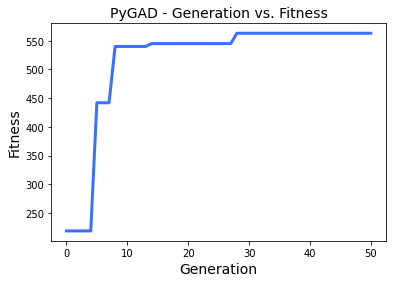

>>>  LEFT SCORED  >>> probability: 0.21000001, 
	position: [7.9 2.1]
	player: [0 0] 
	step: 16 
>>>  LEFT SCORED  >>> probability: 0.3103202386528338, 
	position: [12.1  7.8]
	player: [0 0] 
	step: 43 
>>>  LEFT SCORED  >>> probability: 0.8297067976989677, 
	position: [14.9  3.5]
	player: [0 0] 
	step: 100 
>>>  LEFT SCORED  >>> probability: 0.32642985996946944, 
	position: [9.  3.2]
	player: [0 2] 
	step: 46 
>>>  LEFT SCORED  >>> probability: 0.339760134734536, 
	position: [9.1 5.5]
	player: [0 0] 
	step: 24 
>>>  RIGHT SCORED  >>> probability: 0.3535771511013129, 
	position: [7.4 5.2]
	player: [1 3] 
	step: 57 
>>>  LEFT SCORED  >>> probability: 0.3511341475208298, 
	position: [10.4  2.9]
	player: [0 0] 
	step: 21 
>>>  LEFT SCORED  >>> probability: 0.3466149671625936, 
	position: [8.5 5.3]
	player: [0 2] 
	step: 43 
>>>  LEFT SCORED  >>> probability: 0.489348792153298, 
	position: [14.9  7.8]
	player: [0 0] 
	step: 53 
>>>  LEFT SCORED  >>> probability: 0.302264076387089, 
	positio

<All keys matched successfully>

In [11]:
turn = [200]
tmp_goal_counter = int()
_left = list()
_right = list()
indiv_reward, fga, fgm, stl, stl_attempt = dict(),dict(),dict(),dict(),dict()

global turn, tmp_goal_counter, _left, _right, indiv_reward, fga, fgm, stl, stl_attempt
for t in turn:
    def fitness_func(ga_instance,solution, sol_idx):
        global torch_ga, model, observation_space_size, env, turn,tmp_goal_counter,_left, _right, indiv_reward, fga, fgm, stl, stl_attempt

        model_weights_matrix = torchga.model_weights_as_dict(model=model, weights_vector=solution)
        model.load_state_dict(model_weights_matrix)

        obs_to_txt = {"steps":[]}
        last_val, all_scores = -1, 2
        goal_counter = int()
        env = Basketball_Environment()
        initial_state,_,tmp_scores,indiv_reward, fga, fgm, stl, stl_attempt = env.reset(True)
        observation = np.expand_dims(np.float32(initial_state), axis=0)
        sum_reward = int()
        for _ in range(t):
            actions = []
            obs_to_txt['steps'].append([observation,tmp_scores,indiv_reward, fga, fgm, stl, stl_attempt])
            for i in range(10):
                actions.append(torch.argmax(model(torch.Tensor(observation[:,i])),dim=1).item()) # in case of lstm
                #actions.append(torch.argmax(torch.softmax(model(torch.Tensor(observation[:,i])), dim=0)).item()) # in case of mlp

            observation_next, reward, tmp_scores,indiv_reward, fga, fgm, stl, stl_attempt = env.step(actions=actions)
            observation = np.expand_dims(np.float32(observation_next), axis=0)
            
        goal_counter += sum(list(tmp_scores.values()))
        _left.append(tmp_scores['team_left'])
        _right.append(tmp_scores['team_right'])
        if goal_counter >= tmp_goal_counter:
            tmp_goal_counter = goal_counter
            with open('obs_to_txt.json', 'w') as json_file:
                json.dump([obs_to_txt, tmp_scores,indiv_reward, fga, fgm, stl, stl_attempt], json_file,cls=NumpyEncoder)
            sum_reward += reward
        return sum_reward

    def callback_generation(ga_instance):
        print("Generation = {generation}".format(generation=ga_instance.generations_completed))
        print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

    keras_ga = torchga.TorchGA(model=model, num_solutions=50)

    ga_instance = pygad.GA(num_generations=50,
                           num_parents_mating=10,
                           initial_population=keras_ga.population_weights,
                           fitness_func=fitness_func,
                           parent_selection_type="rws",
                           crossover_type="single_point",
                           mutation_type="random",
                           mutation_percent_genes=30,
                           keep_parents=2,
                           on_generation=callback_generation)

# random population
#     ga_instance = pygad.GA(num_generations=50,
#                            num_parents_mating=10,
#                            sol_per_pop = 50,
#                             num_genes = 2465,
#                            fitness_func=fitness_func,
#                            on_generation=callback_generation)


    ga_instance.run()
    ga_instance.plot_result()
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
    print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))
    model_weights_matrix = torchga.model_weights_as_dict(model=model, weights_vector=solution)
    model.load_state_dict(model_weights_matrix)

model_weights_matrix = torchga.model_weights_as_dict(model=model, weights_vector=solution)
model.load_state_dict(model_weights_matrix)

In [12]:
#torch.save(model.state_dict(), 'Basketball_env.h5')

In [8]:
f = open('obs_to_txt.json')
obs_to_txt = json.load(f)

In [17]:
obs_to_txt, tmp_scores,indiv_reward, fga, fgm, stl, stl_attempt = obs_to_txt[0], obs_to_txt[1], obs_to_txt[2], obs_to_txt[3], obs_to_txt[4], obs_to_txt[5], obs_to_txt[6]

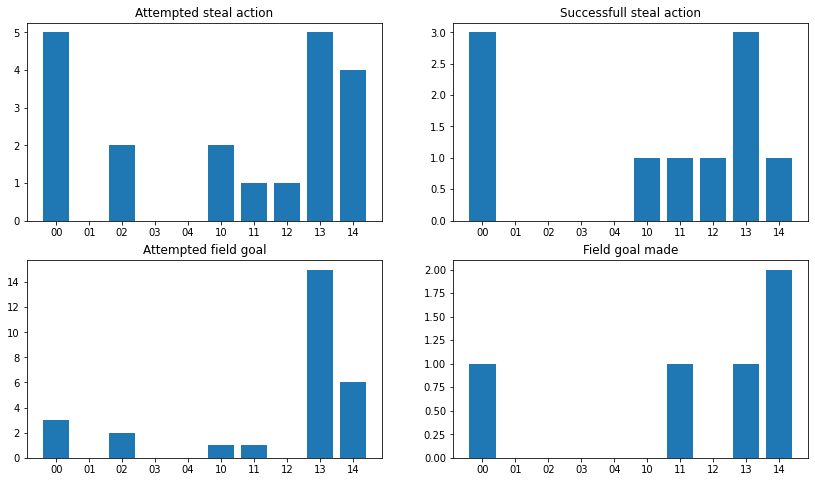

In [18]:
from matplotlib.pyplot import figure
  
figure, axis = plt.subplots(2, 2, figsize=(14, 8))
  
axis[0, 0].bar(list(stl_attempt.keys()),stl_attempt.values())
axis[0, 0].set_title("Attempted steal action")
  
axis[0, 1].bar(list(stl.keys()),stl.values())
axis[0, 1].set_title("Successfull steal action")
  
axis[1, 0].bar(list(fga.keys()),fga.values())
axis[1, 0].set_title("Attempted field goal")
  
axis[1, 1].bar(list(fgm.keys()),fgm.values())
axis[1, 1].set_title("Field goal made")


plt.show()

### Visualization

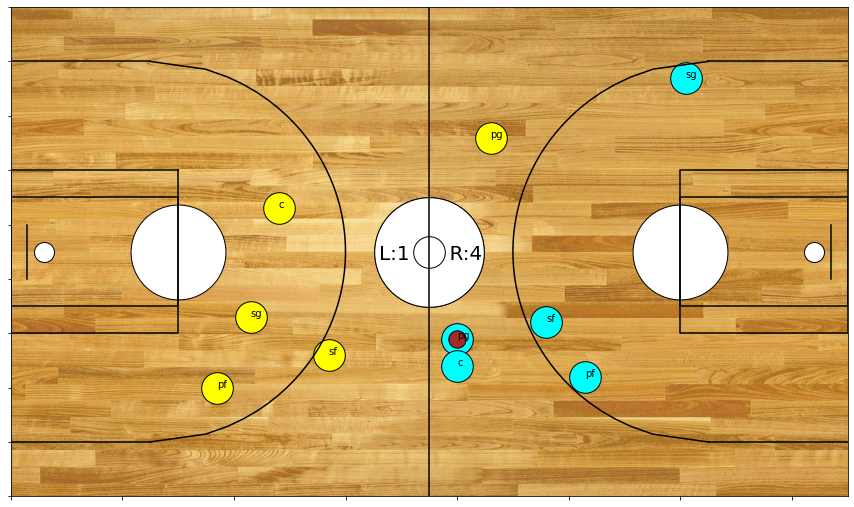

In [9]:
# 1 = random;    2 = model;    3 = log
# 1 random refers to use total random actions from env
# 2 model refers to use model to generate actions
# 3 log refers to observation while training the model of the generation with most goals scored.
##################
                ####
mode = 3        ####
                ####
##################
if mode == 2:
    env = Basketball_Environment()
    initial_state = env.reset()[0]
    observation = np.expand_dims(np.float32(initial_state), axis=0)

if mode == 3:
    f = open('obs_to_txt.json')
    obs_to_txt = json.load(f)

if mode == 3:
    steps =len(obs_to_txt[0]['steps'])
else:
    steps = 100
X = 15 
Y = 9 
rect = patches.Rectangle((5.5, 6.5), 4, 2, linewidth=2, edgecolor='b', facecolor='none')
fig, axs = plt.subplots(1,1, figsize = (X,Y))
axs.set_aspect('equal')
camera = Camera(fig)
#plt.xlabel(f"Team Left: {scores['team_left']} Team Right: {scores['team_right']}", fontsize=18)
s = {'team_left': 0, 'team_right': 0}
players = ['pg','sg','sf','pf','c']
score_left = int()
score_right = int()
for j in range(steps):

    polygonL = Polygon([(3,6), (3,3), (0,3), (0,6)])
    polygonLinside = Polygon([(3,5.5), (3,3.5), (0,3.5), (0,5.5)])

    polygonR = Polygon([(15,6), (15,3), (12,3), (12,6)])
    polygonRinside = Polygon([(15,5.5), (15,3.5), (12,3.5), (12,5.5)])
    if mode == 2:
        s_l = [str(s['team_left'])]
        s_r = [str(s['team_right'])]
    if mode == 3:
        s_l = [str(obs_to_txt[0]['steps'][j][1]['team_left'])]
        s_r = [str(obs_to_txt[0]['steps'][j][1]['team_right'])]
    
    axs.scatter([7.5],[4.5] , color='white', edgecolors='black', marker = 'o', s=12000)
    for i, txt in enumerate(s_r):
        axs.annotate("    R:"+txt, ([7.4][i], [4.35][i]),fontsize=20)
        
    axs.scatter([7.5],[4.5] , color='white', edgecolors='black', marker = 'o', s=12000)
    for i, txt in enumerate(s_l):
        axs.annotate("L:"+txt+"   ", ([6.6][i], [4.35][i]),fontsize=20)
        
    axs.scatter([7.5],[4.5] , color='white', edgecolors='black', marker = 'o', s=1000)
    axs.scatter([3],[4.5] , color='white', edgecolors='black', marker = 'o', s=9000) # big circle close to goal
    axs.scatter([12],[4.5] , color='white', edgecolors='black', marker = 'o', s=9000) # big circle close to goal
    axs.scatter([14.4],[4.5] , color='white', edgecolors='black', marker = 'o', s=400) # goal-left
    axs.scatter([0.6],[4.5] , color='white', edgecolors='black', marker = 'o', s=400) # goal-left
    if score_left < s['team_left']:
        for i in range(3):
            axs.scatter([0.6],[4.5] , color='white', edgecolors='black', marker = 'o', s=400) # goal-left
            axs.scatter([0.6],[4.5] , color='red', edgecolors='black', marker = 'o', s=400) # goal-left
        score_left +=1
    else: pass
    if score_right < s['team_right']:
        for i in range(3):
            axs.scatter([14.4],[4.5] , color='white', edgecolors='black', marker = 'o', s=400) # goal-left
            axs.scatter([14.4],[4.5] , color='red', edgecolors='black', marker = 'o', s=400) # goal-left
        score_right +=1
    else: pass    

    axs.set_xlim(xmin=0.0,xmax=X)
    axs.set_ylim(ymin=0.0,ymax=Y)
    xlm,ylm = polygonL.exterior.xy
    plt.plot(xlm,ylm, c='black')

    xrm,yrm = polygonR.exterior.xy
    plt.plot(xrm,yrm, c='black')
    xlminside,ylminside = polygonLinside.exterior.xy
    plt.plot(xlminside,ylminside,c='black')
    xrminside,yrminside = polygonRinside.exterior.xy
    plt.plot(xrminside,yrminside,c='black')

    x1, y1 = [14.7, 14.7], [4, 5] #line near the goal right-side
    x2, y2 = [0.3, 0.3], [4, 5]  #line near the goal left-side
    plt.plot(x1,y1,x2, y2,color='black')

    x3, y3 = [0, 2.5], [1, 1] # lines close the edges left-side
    x4, y4 = [0, 2.5], [8, 8]
    plt.plot(x3,y3,x4,y4,color='black')

    x5, y5 = [15, 15-2.5], [1, 1] # lines close the edges right-side
    x6, y6 = [15, 15-2.5], [8, 8]
    plt.plot(x5,y5,x6,y6,color='black')

    xMiddle,yMiddle = [7.5,7.5],[0,9]
    plt.plot(xMiddle,yMiddle,color='black')
    ################################# half circles #################################
    a = 3.5
    b = 3.5
    x0 = 4.5
    y0 = 2.5
    x = np.linspace(-a + x0, a + x0)
    y = b * np.sqrt(1 - ((x - x0) / a) ** 2) + y0
    plt.plot(y, x,color='black')

    aR = 3.5
    bR = 3.5
    x0R = 4.5 # half circle up
    y0R = 12.5 # half circle forward
    xR = np.linspace(-aR + x0R, aR + x0R)
    yR = bR * -np.sqrt(1 - ((xR - x0R) / aR) ** 2) + y0R
    plt.plot(yR, xR,color='black')
    ################################# half circles #################################
    if mode == 1:
        vals,_,s,_,_,_,_,_ = env.step(actions = [np.random.randint(0,17) for i in range(10)])
        
        team_left = vals[:5][:,2:4]
        team_right = vals[5:][:,2:4]
        ball_location = vals[:,5:7][0]

    if mode == 2:
        team_left = observation[0][:5][:,2:4]
        team_right = observation[0][5:][:,2:4]
        ball_location = observation[0][:,5:7][0]

    if mode == 3: 
        team_left = np.array(obs_to_txt[0]['steps'][j][0])[0][:5,2:4]
        team_right = np.array(obs_to_txt[0]['steps'][j][0])[0][5:,2:4]
        ball_location = np.array(obs_to_txt[0]['steps'][j][0])[0][:5,5:7][0]


    axs.scatter(team_left[:,0], team_left[:,1], color='yellow', edgecolors='black', marker = 'o', s=1000)
    for i, txt in enumerate(players):
        axs.annotate(txt, (team_left[:,0][i], team_left[:,1][i]))

    axs.scatter(team_right[:,0], team_right[:,1], color='cyan', edgecolors='black', marker = 'o', s=1000)
    for i, txt in enumerate(players):
        axs.annotate(txt, (team_right[:,0][i], team_right[:,1][i]))

    axs.scatter(ball_location[0], ball_location[1], color='brown', edgecolors='black', marker = 'o', s=300)
    camera.snap()
    if mode == 2:
        actions = []
        for indiv in range(10):
            actions.append(torch.argmax(model(torch.Tensor(observation[:,indiv])),dim=1).item())
            #actions.append(torch.argmax(torch.softmax(model(torch.Tensor(observation[:,i])), dim=0)).item())

        observation_next, reward,s,_,_,_,_,_ = env.step(actions=actions)
        observation = np.expand_dims(np.float32(observation_next), axis=0)


    axs.set_yticklabels([])
    axs.set_xticklabels([])

    img = plt.imread("img/court.jpg")
    ext = [0.0, X, 0.0, Y]
    plt.imshow(img, zorder=0, extent=ext)
    plt.gca().set_aspect("auto")
animation = camera.animate()
HTML(animation.to_html5_video())

